In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from lineartree import (
    LinearForestRegressor,
    LinearBoostRegressor,
    LinearTreeRegressor,
)
from sklearn.linear_model import LinearRegression
from lineartree._classes import _predict_branch
from JOPLEn.partitioner import LinearBoostPartition, LinearForestPartition

In [2]:
np.random.seed(0)

n_points = 1000
x = np.random.randn(n_points, 2)
# y = x[:, 0] ** 2 + x[:, 1] + np.random.randn(n_points) * 0.1
y = np.sin(2 * x[:, 0]) + np.cos(2 * x[:, 1]) + np.random.randn(n_points) * 0.1

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [3]:
# Initialize and train the regression tree
tree = LinearTreeRegressor(base_estimator=LinearRegression())

tree.fit(x, y)

LinearTreeRegressor(base_estimator=LinearRegression())

In [4]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=3)
model.fit(x, y)

model.apply(x).T.shape

(3, 1000)

In [5]:
# Predict and evaluate
predictions = tree.predict(x)

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions,
        mode="markers",
        marker=dict(color="blue"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [37]:
from JOPLEn.singletask import JOPLEn

model = JOPLEn(
    partitioner=LinearForestPartition,
    n_cells=8,
    random_state=0,
    n_partitions=100,
)

history = model.fit(x, y, max_iters=1000, print_epochs=50)

pred1 = model.predict(x)

/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



[18:02:34]: Epoch     50 | TrL: 0.948016 | FNorm: 0.028854 | PNorm: 2.905342 | WNz:    3 | Obj: 0.829292
[18:02:34]: Epoch    100 | TrL: 0.751467 | FNorm: 0.327777 | PNorm: 9.806890 | WNz:    3 | Obj: 0.524246
[18:02:34]: Epoch    150 | TrL: 0.597123 | FNorm: 1.038547 | PNorm: 17.496979 | WNz:    3 | Obj: 0.339441
[18:02:34]: Epoch    200 | TrL: 0.535542 | FNorm: 1.821506 | PNorm: 23.237278 | WNz:    3 | Obj: 0.282990
[18:02:34]: Epoch    250 | TrL: 0.495378 | FNorm: 2.333342 | PNorm: 26.367001 | WNz:    3 | Obj: 0.249948
[18:02:34]: Epoch    300 | TrL: 0.452993 | FNorm: 2.649257 | PNorm: 28.132805 | WNz:    3 | Obj: 0.216049
[18:02:34]: Epoch    350 | TrL: 0.424577 | FNorm: 3.019718 | PNorm: 30.035278 | WNz:    3 | Obj: 0.196771
[18:02:34]: Epoch    400 | TrL: 0.402952 | FNorm: 3.551345 | PNorm: 32.548988 | WNz:    3 | Obj: 0.185606
[18:02:34]: Epoch    450 | TrL: 0.383042 | FNorm: 4.182925 | PNorm: 35.294834 | WNz:    3 | Obj: 0.177515
[18:02:34]: Epoch    500 | TrL: 0.370555 | FNorm

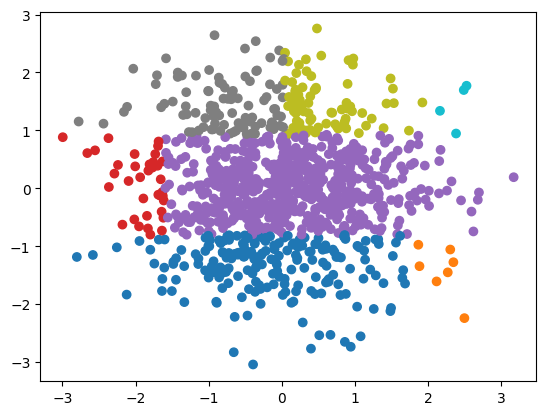

In [35]:
plt.scatter(
    x[:, 0],
    x[:, 1],
    c=model.partitioner.model.forest_estimator_.estimators_[5].apply(x),
    cmap="tab10",
)

In [25]:
from JOPLEn.partitioner import RFPartition

model = JOPLEn(
    partitioner=RFPartition,
    n_cells=8,
    random_state=0,
    n_partitions=100,
)

history = model.fit(x, y, max_iters=1000, print_epochs=50)

pred2 = model.predict(x)

[18:01:13]: Epoch     50 | TrL: 0.950134 | FNorm: 0.028128 | PNorm: 2.866708 | WNz:    3 | Obj: 0.832991
[18:01:13]: Epoch    100 | TrL: 0.738735 | FNorm: 0.336814 | PNorm: 9.923563 | WNz:    3 | Obj: 0.506837
[18:01:13]: Epoch    150 | TrL: 0.531907 | FNorm: 1.150706 | PNorm: 18.352819 | WNz:    3 | Obj: 0.272655
[18:01:13]: Epoch    200 | TrL: 0.440214 | FNorm: 2.173067 | PNorm: 25.238693 | WNz:    3 | Obj: 0.200730
[18:01:13]: Epoch    250 | TrL: 0.429022 | FNorm: 2.855152 | PNorm: 28.951136 | WNz:    3 | Obj: 0.198614
[18:01:13]: Epoch    300 | TrL: 0.419719 | FNorm: 2.991570 | PNorm: 29.646156 | WNz:    3 | Obj: 0.192702
[18:01:13]: Epoch    350 | TrL: 0.409120 | FNorm: 2.811006 | PNorm: 28.715424 | WNz:    3 | Obj: 0.182784
[18:01:13]: Epoch    400 | TrL: 0.406579 | FNorm: 2.634830 | PNorm: 27.728241 | WNz:    3 | Obj: 0.179101
[18:01:13]: Epoch    450 | TrL: 0.402834 | FNorm: 2.634452 | PNorm: 27.618387 | WNz:    3 | Obj: 0.176300
[18:01:13]: Epoch    500 | TrL: 0.395237 | FNorm

In [38]:
# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Add the predictions from each method
# fig.add_trace(
#     go.Scatter3d(
#         x=x[:, 0],
#         y=x[:, 1],
#         z=pred1.flatten(),
#         mode="markers",
#         marker=dict(color="blue"),
#         name="Linear Forest",
#     )
# )

fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=pred2.flatten(),
        mode="markers",
        marker=dict(color="green"),
        name="Random Forest",
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [ ]:
np.random.seed(0)

x = np.random.randn(1000, 2)
y = np.sin(2 * x[:, 0]) + np.cos(2 * x[:, 1]) + np.random.randn(1000) * 0.1

# model = VarMaxForest(n_estimators=10, max_depth=3, min_samples_leaf=100)
model = JOPLEn(
    partitioner=VarMaxForestPartition,
    n_cells=8,
    random_state=0,
    n_partitions=100,
    part_kwargs={"min_samples_leaf": 20},
)

history = model.fit(x, y, max_iters=1000, print_epochs=50, mu=0.1)

predictions = model.predict(x).flatten()

[17:42:14]: Epoch     50 | TrL: 0.410175 | FNorm: 9.842708 | PNorm: 53.482536 | WNz:    3 | Obj: 0.254147
[17:42:14]: Epoch    100 | TrL: 0.340393 | FNorm: 12.674873 | PNorm: 60.407150 | WNz:    3 | Obj: 0.234227
[17:42:15]: Epoch    150 | TrL: 0.338747 | FNorm: 12.683508 | PNorm: 60.413597 | WNz:    3 | Obj: 0.233282
[17:42:15]: Epoch    200 | TrL: 0.345817 | FNorm: 12.225052 | PNorm: 59.330666 | WNz:    3 | Obj: 0.233151
[17:42:15]: Epoch    250 | TrL: 0.341691 | FNorm: 12.475643 | PNorm: 59.938072 | WNz:    3 | Obj: 0.233046
[17:42:15]: Epoch    300 | TrL: 0.342397 | FNorm: 12.428420 | PNorm: 59.830765 | WNz:    3 | Obj: 0.233019
[17:42:15]: Epoch    350 | TrL: 0.343110 | FNorm: 12.383019 | PNorm: 59.690998 | WNz:    3 | Obj: 0.233014
[17:42:15]: Epoch    400 | TrL: 0.342525 | FNorm: 12.418893 | PNorm: 59.805496 | WNz:    3 | Obj: 0.233003
[17:42:15]: Epoch    450 | TrL: 0.342350 | FNorm: 12.429291 | PNorm: 59.826954 | WNz:    3 | Obj: 0.232997
[17:42:15]: Epoch    500 | TrL: 0.3430

In [ ]:
# Create a figure
fig = go.Figure()

# # Add the first scatter plot
# fig.add_trace(
#     go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
# )

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions,
        mode="markers",
        marker=dict(color="blue"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [ ]:
from JOPLEn.partitioner import RFPartition

model = JOPLEn(
    partitioner=RFPartition,
    n_cells=8,
    random_state=0,
    n_partitions=100,
    part_kwargs={"min_samples_leaf": 20},
)

history = model.fit(x, y, max_iters=1000, print_epochs=50, mu=0.1)

predictions = model.predict(x).flatten()

[17:42:15]: Epoch     50 | TrL: 0.392925 | FNorm: 2.895354 | PNorm: 28.851131 | WNz:    3 | Obj: 0.171649
[17:42:16]: Epoch    100 | TrL: 0.364995 | FNorm: 4.141450 | PNorm: 34.001842 | WNz:    3 | Obj: 0.164635
[17:42:16]: Epoch    150 | TrL: 0.361766 | FNorm: 4.352855 | PNorm: 34.771130 | WNz:    3 | Obj: 0.164592
[17:42:16]: Epoch    200 | TrL: 0.366198 | FNorm: 4.046901 | PNorm: 33.577728 | WNz:    3 | Obj: 0.164497
[17:42:16]: Epoch    250 | TrL: 0.365413 | FNorm: 4.098181 | PNorm: 33.824806 | WNz:    3 | Obj: 0.164482
[17:42:16]: Epoch    300 | TrL: 0.364668 | FNorm: 4.145901 | PNorm: 33.967735 | WNz:    3 | Obj: 0.164460
[17:42:16]: Epoch    350 | TrL: 0.364873 | FNorm: 4.132380 | PNorm: 33.916092 | WNz:    3 | Obj: 0.164461
[17:42:16]: Epoch    400 | TrL: 0.365041 | FNorm: 4.120670 | PNorm: 33.903099 | WNz:    3 | Obj: 0.164458
[17:42:16]: Epoch    450 | TrL: 0.365178 | FNorm: 4.111416 | PNorm: 33.840302 | WNz:    3 | Obj: 0.164456
[17:42:16]: Epoch    500 | TrL: 0.364888 | FNo

In [ ]:
# Create a figure
fig = go.Figure()

# # Add the first scatter plot
# fig.add_trace(
#     go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
# )

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions,
        mode="markers",
        marker=dict(color="blue"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()